In [115]:
%matplotlib notebook
from pathlib import Path
import cartopy.crs as ccrs
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import stats
import statsmodels.api as sm
import datetime 
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import math
import statistics
from numpy import*
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime

In [116]:
file=Path(r"D:\Datasets\XTRACK\ESACCI-SEALEVEL-L3-SLA-N_INDIAN-MERGED-20200113-JA-053-fv01.1.nc")
ds=xr.open_dataset(file,decode_times=False)

In [105]:
def select_point(ds,point):
    ''' select a point in a track and return a dict with needed parameters'''
    #ref=pd.Timestamp(1950,1,1)
    output={}
    print(f"extract point #{point} on track {ds.pass_number}")
    output["dist"]=ds.dist_to_coast_gshhs[point].values/1000.
    output['pt']=point
    output["location"]=[ds.lon[point].values,ds.lat[point].values]
    #time = pd.to_datetime(ds.time[point,:], unit='D', origin=ref)
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    output["ts"]=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    output["valid"] = (1-(output['ts'].isna().sum().values[0] / len(output['ts'])))*100.
    output["trend"],intercept,std_error= trend_ols(sla.values,ds.time[point,:].values)
    output['trend_rate_with_outlier']=output["trend"]*1000*365
    output['flagged']=sigma_mask(output['ts'])
    return output

def sigma_mask(df,n=2):
    '''''''removing outliers'''
    sigma = df.std()
    mask = (df >- n*sigma) & (df < n*sigma)
    df_masked=df[mask.values]
    return df_masked

def flagged_trend(ds,point):
    
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    df=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    df_masked=sigma_mask(df,n=2)
    slope,intercept,std_error=trend_ols(df_masked.values,df_masked.index.values)
    trend_rate=slope*1000*365
    print ('trend rate is :',(trend_rate),'mm/yr' )


def plot_point(ds,point):
    '''ploting points without outliers'''
    ref=pd.Timestamp(1950,1,1)
    output=select_point(ds,point)
    title=f"Point No: {point} - Distance to Coast: {output['dist']:.2f} km-{output['valid']:.2f}%"
    df=output['ts']
    df_flagged=output['flagged']
    time=pd.to_datetime(output['ts'].index, unit='D', origin=ref)
    time_flagged=pd.to_datetime(output['flagged'].index, unit='D', origin=ref)

    #plots
    fig,ax=plt.subplots()
    figsize=(20,20)
    ax.scatter(time,df.values,color='red')
    ax.plot(time_flagged,df_flagged.values,color='skyblue')
    slope,intercept,std_error=trend_ols(df_flagged.values,df_flagged.index.values)
    s_mm=slope*1000*365
    s_mm="%.2f" % s_mm
    e_mm=std_error*1000*365
    e_mm="%.2f" % e_mm
    label=f"{s_mm} mm/yr +/- {e_mm} mm/yr"
    y_fit=  slope*df_flagged.index.values+intercept
    ax.plot(time_flagged,y_fit,linewidth=2.,c='green',label=label)
    ax.set_yticks(np.arange(-0.5, 1, 0.5))
    ax.set_title(title)
    ax.legend(loc=1)
    plt.ylabel("Sea Level Anomaly (m)")
    plt.grid()
    return ax

def trend_ols(y,x,summary=False):
    ''' '''
    model=sm.OLS(y,sm.add_constant(x),missing='drop')
    results=model.fit()
    intercept,slope = results.params
    std_error=results.bse[1]
    y_fit=  slope*x+intercept
    if summary :
        print(results.summary())
    else :
        print(f"the slope is {slope}")
        print (f"the standard error is {results.bse[1]}")
        #print ('trend rate is :',(trend_rate),'mm/yr' )
    return slope,intercept,std_error

def map_selected_point(ds,point,extent=None):
    dl=1.
    if extent is None :
        extent = [ds.lon.min()-dl, ds.lon.max()+dl, ds.lat.min()-dl, ds.lat.max()+dl]
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines(resolution='10m') 
    ax.gridlines(draw_labels=True)
    ax.scatter(ds.lon.values,ds.lat.values,color='black',marker='.')
    ax.scatter(ds.lon[point].values,ds.lat[point].values,color='red',marker='o',zorder=1)
    return ax


In [91]:
ds

<xarray.Dataset>
Dimensions:                         (nbcycles: 603, nbpoints: 8503)
Dimensions without coordinates: nbcycles, nbpoints
Data variables: (12/14)
    qual_flag                       (nbpoints) int8 ...
    biasJ1J2                        (nbpoints) float64 ...
    biasJ2J3                        (nbpoints) float64 ...
    cycle                           (nbcycles) int32 ...
    dist_to_coast_gshhs             (nbpoints) float64 ...
    lat                             (nbpoints) float32 ...
    ...                              ...
    missions_cycles                 (nbcycles) float32 ...
    sla                             (nbpoints, nbcycles) float32 ...
    time                            (nbpoints, nbcycles) float64 ...
    ocean_tide                      (nbpoints, nbcycles) float32 ...
    dynamic_atmospheric_correction  (nbpoints, nbcycles) float32 ...
    mean_sea_surface                (nbpoints) float32 ...
Attributes: (12/40)
    title:                     SL_cci+ L3 X-TRACK/ALES Altimeter Sea Level An...
    institution:               ESA, CTOH/LEGOS, Toulouse Univ., CNRS, IRD, CN...
    Conventions:               CF-1.6
    history:                   2020-01-13 generated by X-TRACK v.1.03
    version:                   X-TRACK/ALES 1.1
    pass_number:               053
    ...                        ...
    platform:                  Jason-1, Jason-2 and Jason-3
    sensor:                    Poseidon-2, Poseidon-3 and Poseidon-3B
    spatial_resolution:        350 m
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    key_variables:             sea_surface_height_above_mean_sea_level

<IPython.core.display.Javascript object>


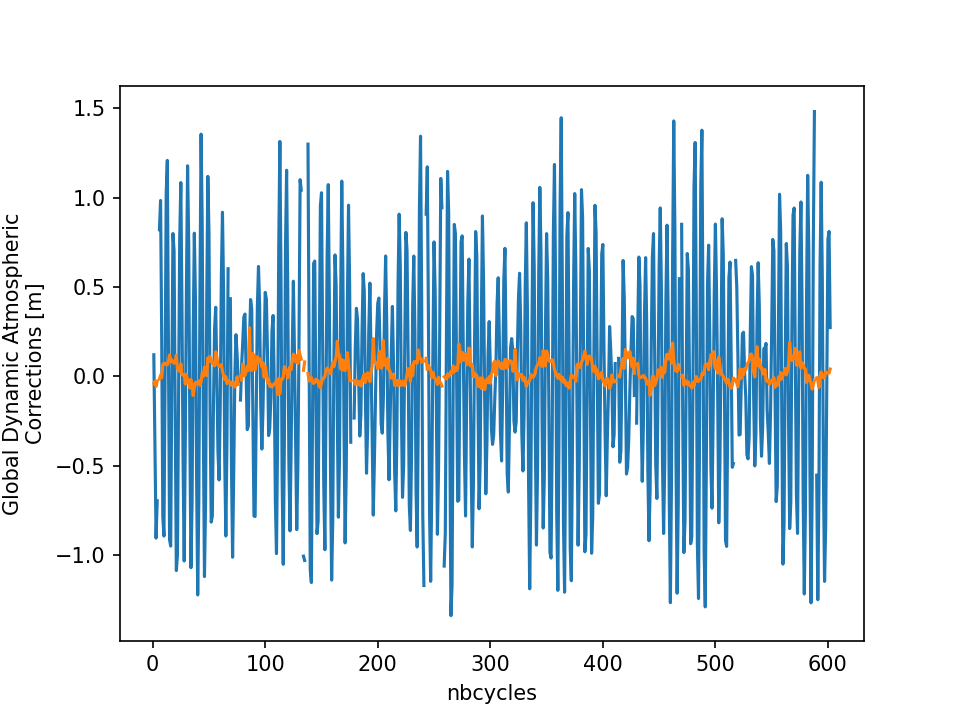

In [118]:
ds.ocean_tide[-500,:].plot()
ds.dynamic_atmospheric_correction[-500,:].plot()
plt.show()

<IPython.core.display.Javascript object>


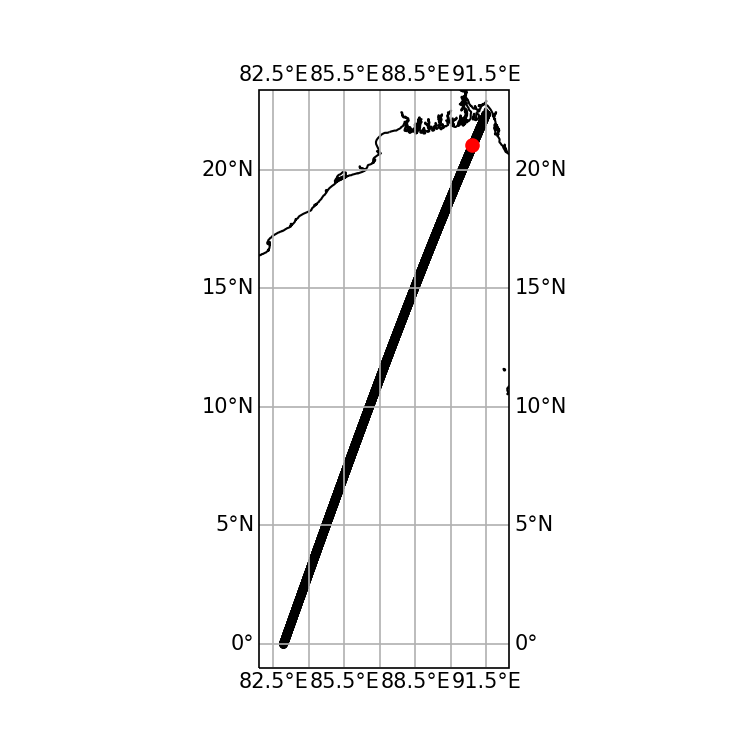

In [103]:
map_selected_point(ds,-500)

extract point #-500 on track 053
the slope is 1.1354887900025703e-05
the standard error is 4.245418408219086e-06


<IPython.core.display.Javascript object>


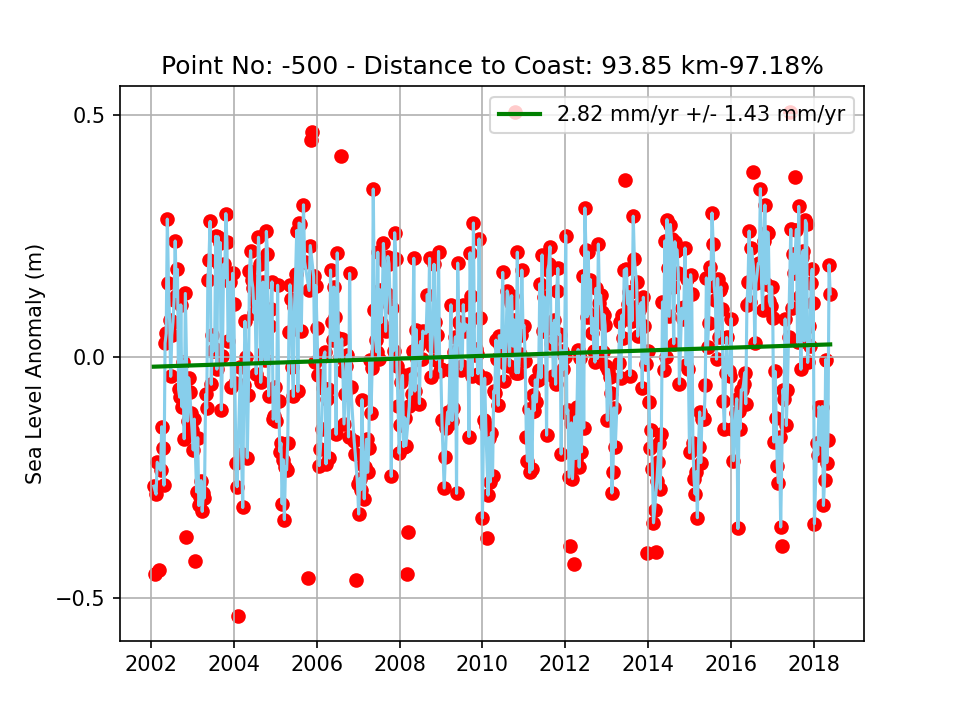

the slope is 7.732150162668834e-06
the standard error is 3.905329475491962e-06
extract point #-499 on track 053
the slope is 8.464626654168681e-06
the standard error is 4.121519304832428e-06


<IPython.core.display.Javascript object>


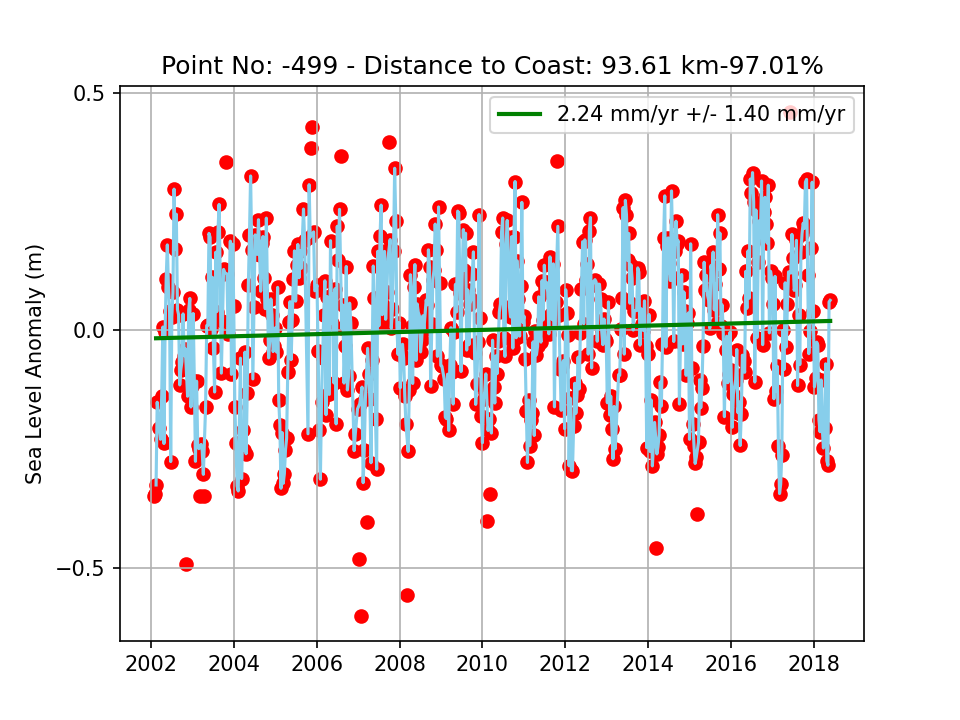

the slope is 6.1450405266963994e-06
the standard error is 3.826198841987753e-06
extract point #-50 on track 053
the slope is 1.5333378601281057e-05
the standard error is 1.2780201166867508e-05


<IPython.core.display.Javascript object>


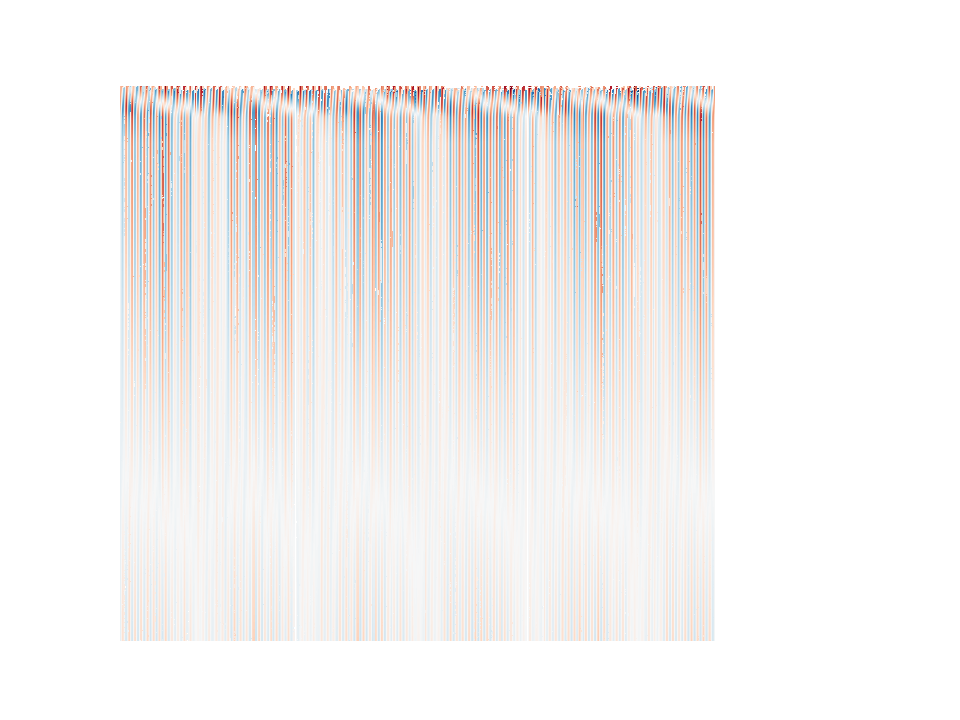

the slope is 1.8990400322044946e-05
the standard error is 1.2371410057689443e-05


In [110]:
a=plot_point(ds,-500)
a=plot_point(ds,-499)
a=plot_point(ds,-50)

In [85]:
b=select_point(ds,8100)

extract point #8100 on track 014
the slope is 9.539269297046303e-06
the standard error is 4.236967950881924e-06


In [86]:
b

{'dist': 32.139469281626866,
 'pt': 8100,
 'location': [array(87.58343, dtype=float32), array(21.296898, dtype=float32)],
 'ts':               X-TRACK/ALES Sea Level Anomalies
 time                                          
 19007.737829                         -0.259961
 NaN                                        NaN
 19027.569096                         -0.298821
 19037.484742                         -0.270109
 19047.400382                         -0.224717
 ...                                        ...
 24937.294446                         -0.140772
 24947.210097                          0.031408
 24957.125746                         -0.142321
 24967.041393                         -0.045638
 24976.957038                         -0.031173
 
 [603 rows x 1 columns],
 'valid': 95.02487562189054,
 'trend': 9.539269297046303e-06,
 'trend_rate_with_outlier': 3.481833293421901,
 'flagged':               X-TRACK/ALES Sea Level Anomalies
 time                                          
 1900

In [87]:
df=b['flagged']
df

,X-TRACK/ALES Sea Level Anomalies
time,
19007.737829,-0.259961
19027.569096,-0.298821
19037.484742,-0.270109
19047.400382,-0.224717
19057.316016,-0.321447
...,...
24937.294446,-0.140772
24947.210097,0.031408
24957.125746,-0.142321


In [88]:
flagged_trend(ds,8100)

the slope is 5.872967748004145e-06
the standard error is 3.941605951391626e-06
trend rate is : 2.143633228021513 mm/yr


In [89]:
trend=trend_ols(df.values,df.index.values,summary=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.220
Date:                Thu, 18 Mar 2021   Prob (F-statistic):              0.137
Time:                        15:35:51   Log-Likelihood:                 227.16
No. Observations:                 555   AIC:                            -450.3
Df Residuals:                     553   BIC:                            -441.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1339      0.087     -1.536      0.1